# exploration of the optimized classification model

In [1]:
import numpy as np
import pandas as pd
from time import time
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from random import randint
import os
import matplotlib.pyplot as plt
import tensorflow_addons as tfa


import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import plotting_funcs as pf
import preprocessing as prep
import clustering_model as cm
import config as conf

from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

In [2]:
X = np.load('x_balanced_sample_16.npy')
y = np.load('y_balanced_sample_16.npy')
types = np.array([conf.wells_to_genetype_dict[well] for well in y])
y_letter = np.array([well[:1] for well in y])
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
#labs = le.fit_transform(y)
#labs_by_letter = le.fit_transform(y_letter)

labs_by_type = le.fit_transform(types)
labs_by_type = to_categorical(labs_by_type)
X_XY = X[:,:,:2]
X_added = prep.add_transformations(X)
print(X_XY.shape , labs_by_type.shape)

(10000, 16, 2) (10000, 5)


<AxesSubplot:>

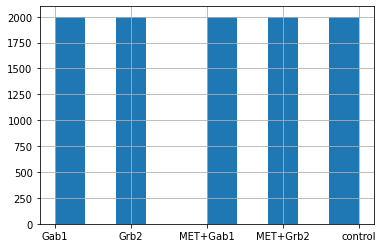

In [3]:
pd.Series(types).hist()

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X_XY,labs_by_type,test_size=0.2,random_state=42)

In [5]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(8000, 16, 2) (8000, 5)
(2000, 16, 2) (2000, 5)


In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [7]:
#model params
input_dim = X_train.shape[-1]
num_labels = len(np.unique(types))
timesteps = X_train.shape[-2]
n_filters = [128,64,64,32]
kernel_size = 16
strides = 1
pool_size = 8
n_units = [128,16]

optimizer='adam'
#optimizer = Adam(lr=0.01)
#loss = 'categorical_crossentropy' # need one ot encoded labels
loss = 'categorical_crossentropy' # need label encoded labels
epochs=100
batch_size=256
save_dir='results/tmp'
verbose=1
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [8]:
classifier_model = cm.temporal_classifier(input_dim,num_labels,timesteps,n_filters,kernel_size,pool_size,n_units)
classifier_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.AUC(multi_label = True,name='auc')])
classifier_model.summary()

2022-09-12 22:35:09.227177: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_seq (InputLayer)      [(None, 16, 2)]           0         
                                                                 
 conv1d (Conv1D)             (None, 16, 128)           4224      
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 64)            131136    
                                                                 
 conv1d_2 (Conv1D)           (None, 16, 64)            65600     
                                                                 
 conv1d_3 (Conv1D)           (None, 16, 32)            32800     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 32)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 32)            0

## on X and Y only

In [9]:
t0 = time()
history = classifier_model.fit(X_train, y_train,validation_data=(X_test,y_test) , batch_size=batch_size, epochs=epochs, verbose=verbose, callbacks=es)
print('Pretraining time: ', time() - t0)

Epoch 1/100
32/32 [==============================] - 10s 117ms/step - loss: 1.6078 - accuracy: 0.2180 - auc: 0.5210 - val_loss: 1.6008 - val_accuracy: 0.2395 - val_auc: 0.5492
Epoch 2/100
32/32 [==============================] - 2s 70ms/step - loss: 1.5960 - accuracy: 0.2460 - auc: 0.5597 - val_loss: 1.5799 - val_accuracy: 0.2685 - val_auc: 0.5874
Epoch 3/100
32/32 [==============================] - 2s 71ms/step - loss: 1.5543 - accuracy: 0.2878 - auc: 0.6094 - val_loss: 1.5155 - val_accuracy: 0.3285 - val_auc: 0.6421
Epoch 4/100
32/32 [==============================] - 2s 76ms/step - loss: 1.4885 - accuracy: 0.3341 - auc: 0.6575 - val_loss: 1.4606 - val_accuracy: 0.3720 - val_auc: 0.6765
Epoch 5/100
32/32 [==============================] - 3s 82ms/step - loss: 1.4036 - accuracy: 0.3943 - auc: 0.7085 - val_loss: 1.4079 - val_accuracy: 0.3960 - val_auc: 0.7106
Epoch 6/100
32/32 [==============================] - 3s 81ms/step - loss: 1.3444 - accuracy: 0.4297 - auc: 0.7381 - val_loss: 1.

accuracy: Train: 0.621, Test: 0.471
auc: Train: 0.882, Test: 0.765


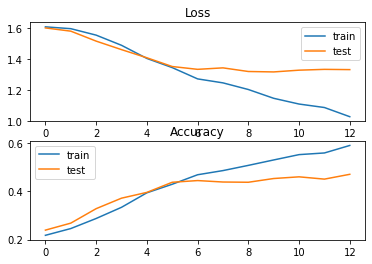

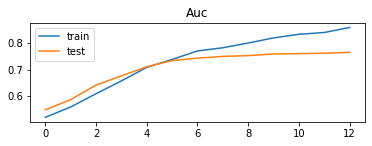

In [10]:
_,train_acc,train_auc = classifier_model.evaluate(X_train, y_train, verbose=0)
_,test_acc,test_auc = classifier_model.evaluate(X_test, y_test, verbose=0)
print('accuracy: Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('auc: Train: %.3f, Test: %.3f' % (train_auc, test_auc))
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()
# plot auc during training
plt.subplot(212)
plt.title('Auc')
plt.plot(history.history['auc'], label='train')
plt.plot(history.history['val_auc'], label='test')
plt.legend()
plt.show()

In [11]:
y_pred = classifier_model.predict(X_test)
confusion = tf.math.confusion_matrix(
              labels = np.argmax(y_test, axis=1),      # get trule labels 
              predictions = np.argmax(y_pred, axis=1),  # get predicted labels 
              num_classes=num_labels) 

63/63 [==============================] - 2s 10ms/step


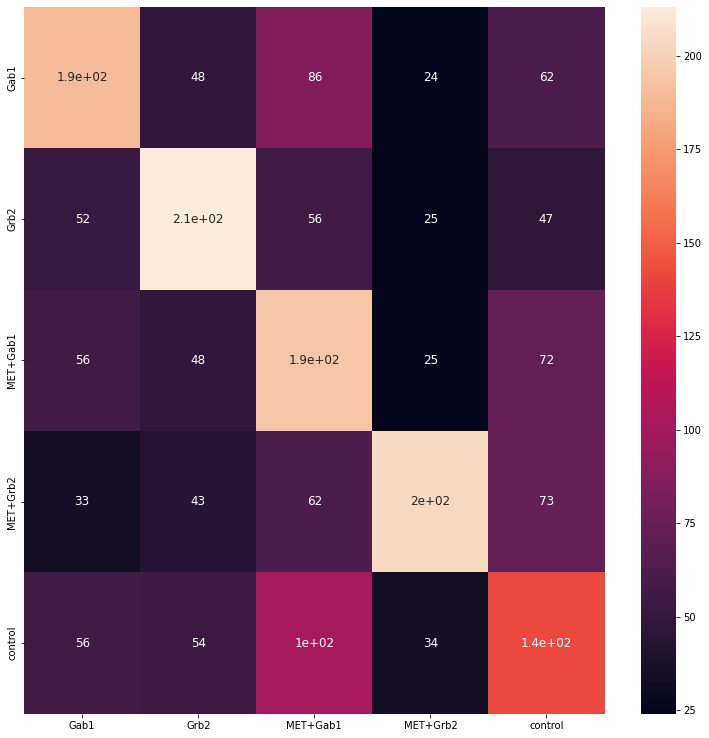

In [12]:
import seaborn as sns 
import pandas as pd 

cm = pd.DataFrame(confusion.numpy(), # use .numpy(), because now confusion is tensor
               le.inverse_transform(range(num_labels)),le.inverse_transform(range(num_labels)))

plt.figure(figsize = (13,13))
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

<AxesSubplot:>

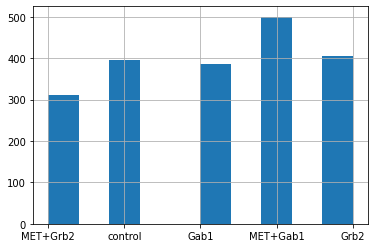

In [13]:
y_pred_types = le.inverse_transform(np.argmax(y_pred, axis=1))
pd.Series(y_pred_types).hist()

<AxesSubplot:>

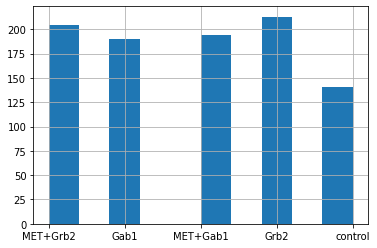

In [14]:
y_pred_correct_idx = np.where((np.argmax(y_test, axis=1))==(np.argmax(y_pred, axis=1)))
y_pred_correct = y_pred[y_pred_correct_idx]
x_pred_correct = X_test[y_pred_correct_idx]
y_pred_correct_types = le.inverse_transform(np.argmax(y_pred_correct, axis=1))
pd.Series(y_pred_correct_types).hist()

<AxesSubplot:>

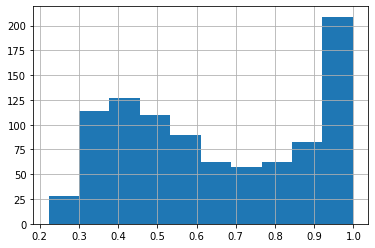

In [15]:
y_true_conf = np.max(y_pred_correct,axis=1)
pd.Series(y_true_conf).hist()

In [16]:
idx_conf_high = np.where(y_true_conf>0.85)
idx_conf_low = np.where(y_true_conf<0.35)

In [17]:
x_rep_high = x_pred_correct[idx_conf_high]
y_rep_high = y_pred_correct_types[idx_conf_high]
x_rep_low = x_pred_correct[idx_conf_low]
y_rep_low = y_pred_correct_types[idx_conf_low]
#pf.plot_representatives()

In [18]:
pd.Series(y_rep_high).value_counts()
#we can see control group is missing - since its the most often confused group (exists in all labels)

Grb2        132
MET+Grb2     70
Gab1         55
MET+Gab1     30
dtype: int64

In [19]:
pd.Series(y_rep_low).value_counts()

control     40
Gab1        17
MET+Gab1    14
MET+Grb2    14
Grb2         9
dtype: int64

/Users/amosavni/university/DeepLearningWorkshop/deepcell_mod/DL-WORKSHOP/Submission/Clustering/plotting_funcs.py:83: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


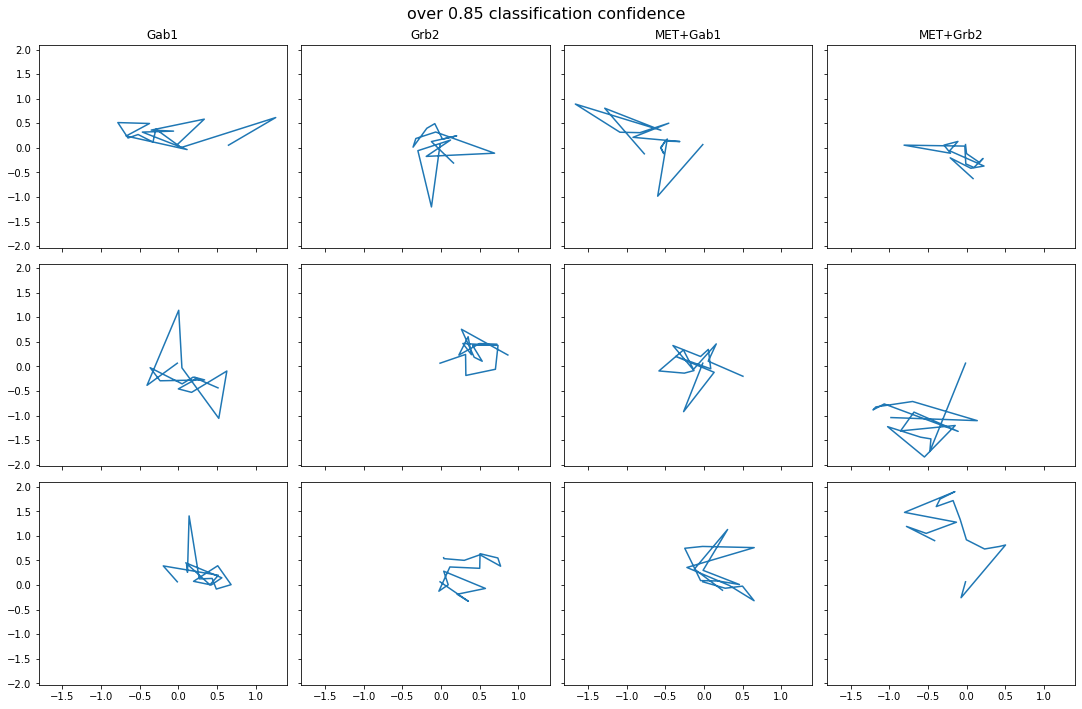

In [20]:
pf.plot_representatives_by_label(x_rep_high,y_rep_high,'over 0.85 classification confidence',3,figsize=(15,10))

/Users/amosavni/university/DeepLearningWorkshop/deepcell_mod/DL-WORKSHOP/Submission/Clustering/plotting_funcs.py:83: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


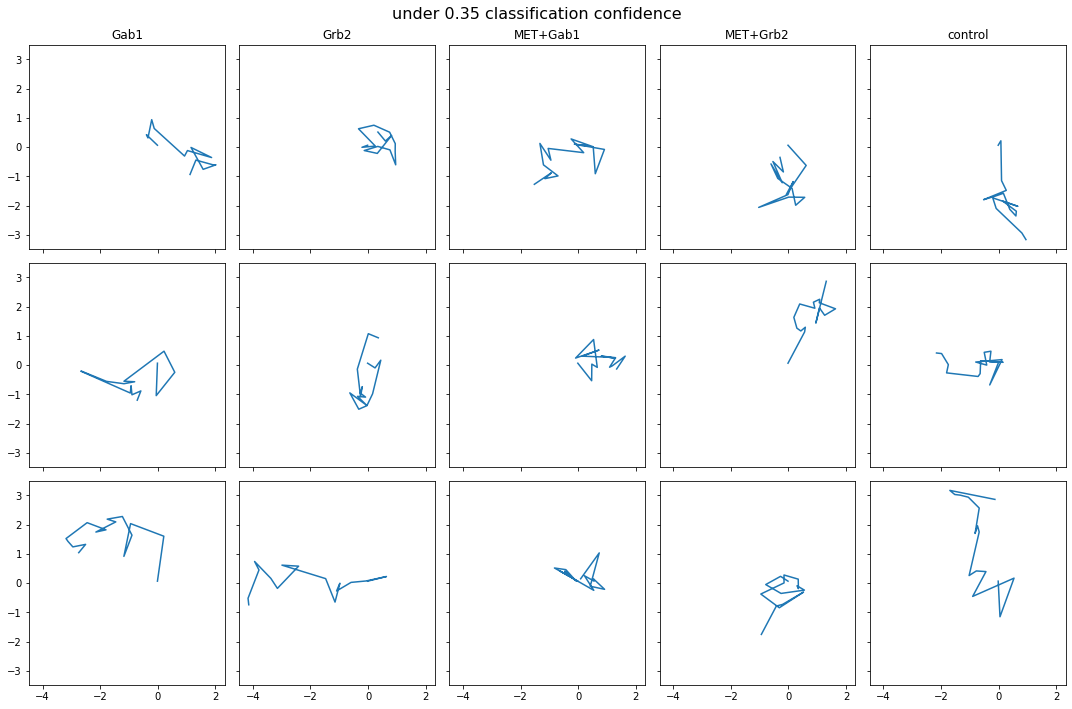

In [21]:
pf.plot_representatives_by_label(x_rep_low,y_rep_low,'under 0.35 classification confidence',3,figsize=(15,10))